In [1]:
# Change directory to VSCode workspace root 
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass



/Users/bpedigo/JHU_code/maggot_models


# Initialize functions and parameters

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import pairwise_distances

from graspy.embed import AdjacencySpectralEmbed
from graspy.models import DCSBMEstimator, HSBMEstimator
from graspy.plot import gridplot, heatmap, hierplot, pairplot, screeplot

from graspy.utils import binarize, get_lcc, import_graph, pass_to_ranks, to_laplace
from src.data import load_june
from src.utils import (
    get_best,
    get_simple,
    get_subgraph,
    meta_to_array,
    savefig,
    to_simple_class,
)

graph_type = "Gadn"
weight_threshold = 0.01
font_scale = 1.5
gridplot_kws = dict(
    hier_label_fontsize=15,
    title_pad=140,
    sizes=(1, 3),
    height=15,
    transform="simple-all",
    sort_nodes=True,
    font_scale=font_scale
)

%matplotlib inline
plt.style.use("seaborn-white")
sns.set_palette("deep")
sns.set_context("paper", font_scale=font_scale)
np.random.seed(8888)

def normalized_ase(graph, n_components=None, embed_kws={}):
    ase = AdjacencySpectralEmbed(n_components=n_components, **embed_kws)
    latent = ase.fit_transform(graph)
    if isinstance(latent, tuple):
        latent = np.concatenate(latent, axis=-1)
    norm_vec = np.linalg.norm(latent, axis=1)
    norm_vec[norm_vec == 0] = 1
    norm_latent = latent / norm_vec[:, np.newaxis]
    return norm_latent


/miniconda3/envs/maggot_models/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Graph preprocessing

Loading graph
Number of nodes: 2277
Number of edges: 49186


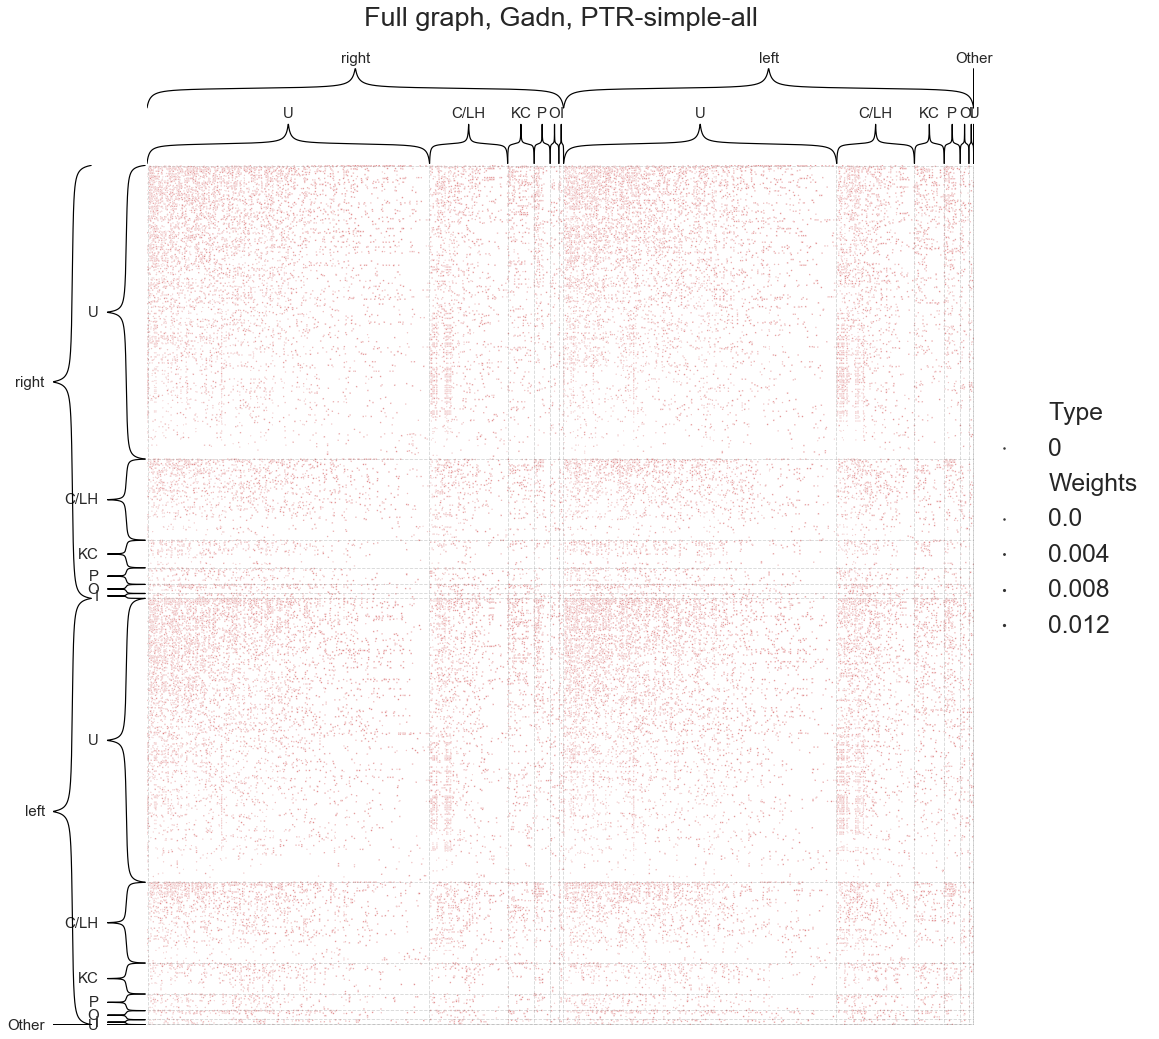

In [3]:
print("Loading graph")


full_graph = load_june(graph_type)
simple_classes = get_simple(full_graph)
hemisphere = meta_to_array(full_graph, "Hemisphere")

n_nodes = len(full_graph)
n_edges = len(full_graph.edges())

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")

gridplot(
    [full_graph],
    inner_hier_labels=simple_classes,
    outer_hier_labels=hemisphere,
    title="Full graph, Gadn, PTR-simple-all",
    **gridplot_kws,
);

Performing edge weight thresholding
Number of edges remaining: 31384
Removed 0.3619322571463425 of edges


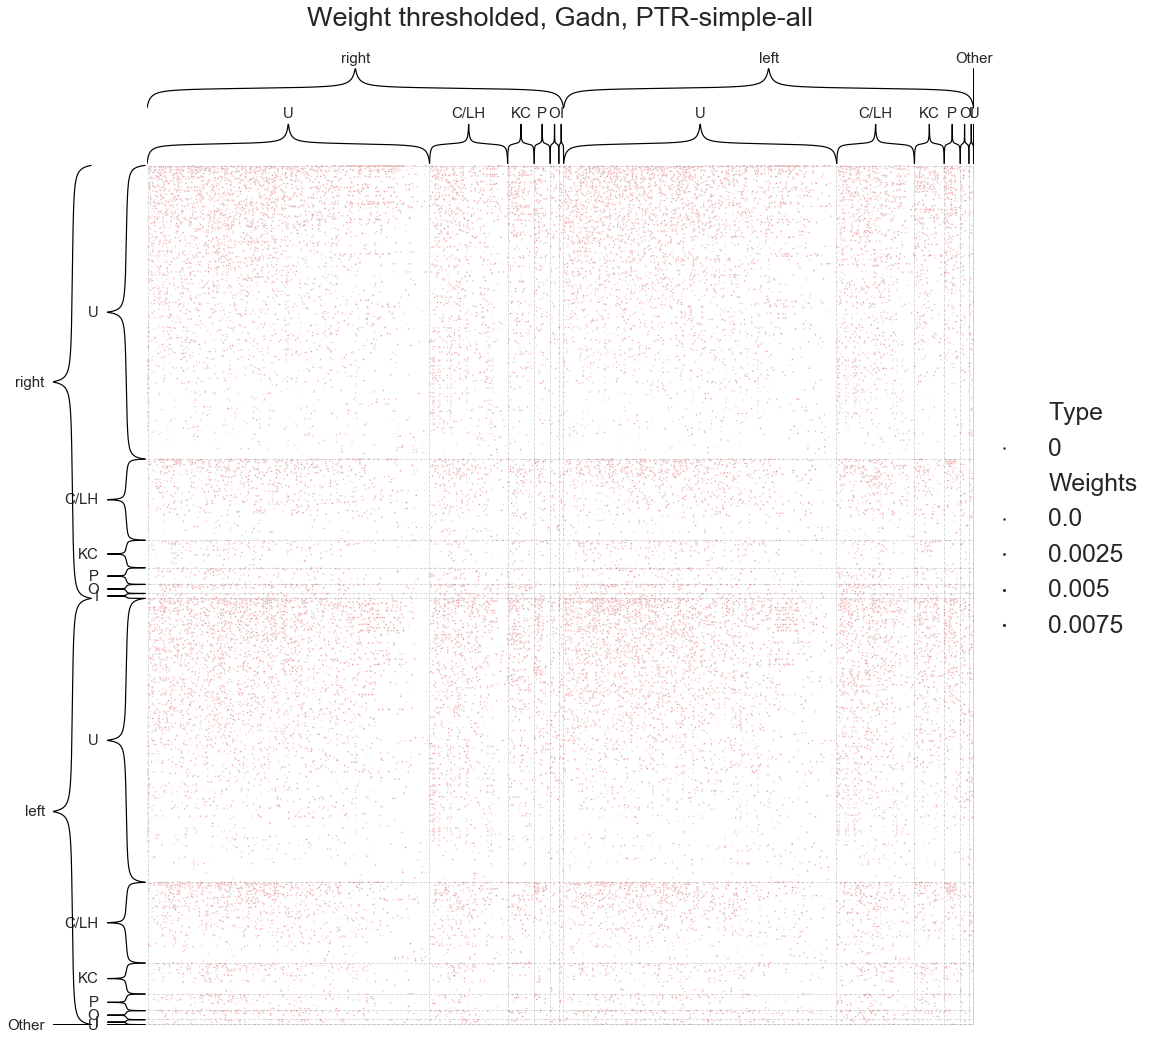

In [4]:
print("Performing edge weight thresholding")
full_graph_t = full_graph.copy()
full_graph_t = import_graph(full_graph_t)
full_graph_t[full_graph_t < 0.01] = 0
n_edges_t = np.count_nonzero(full_graph_t)

print(f"Number of edges remaining: {n_edges_t}")
print(f"Removed {(n_edges - n_edges_t) / n_edges} of edges")

gridplot(
    [full_graph_t],
    inner_hier_labels=simple_classes,
    outer_hier_labels=hemisphere,
    title="Weight thresholded, Gadn, PTR-simple-all",
    **gridplot_kws,
);

In [5]:
print("Finding largest connected component")
lcc_graph_t, lcc_inds = get_lcc(full_graph_t, return_inds=True)
lcc_simple_classes = simple_classes[lcc_inds]
lcc_hemisphere = hemisphere[lcc_inds]
n_nodes_t = lcc_graph_t.shape[0]
print(f"Number of remaining nodes: {n_nodes_t}")
print(f"Removed {(n_nodes - n_nodes_t) / n_nodes} of nodes")

Finding largest connected component
Number of remaining nodes: 2268
Removed 0.003952569169960474 of nodes


# Graph embedding
- Scree plot 
- Graph that was embedded 
- ASE embedding 
- ASE after projecting to the unit hypersphere
- Using ZG1 for the first embedding stage

Embedding binarized graph, n_components from ZG1
Red shows elbows [1, 2, 3] found by ZG


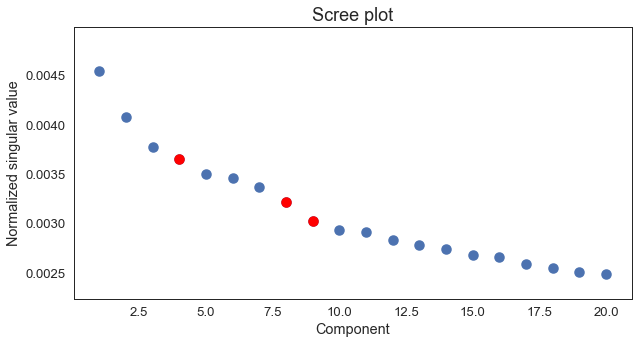

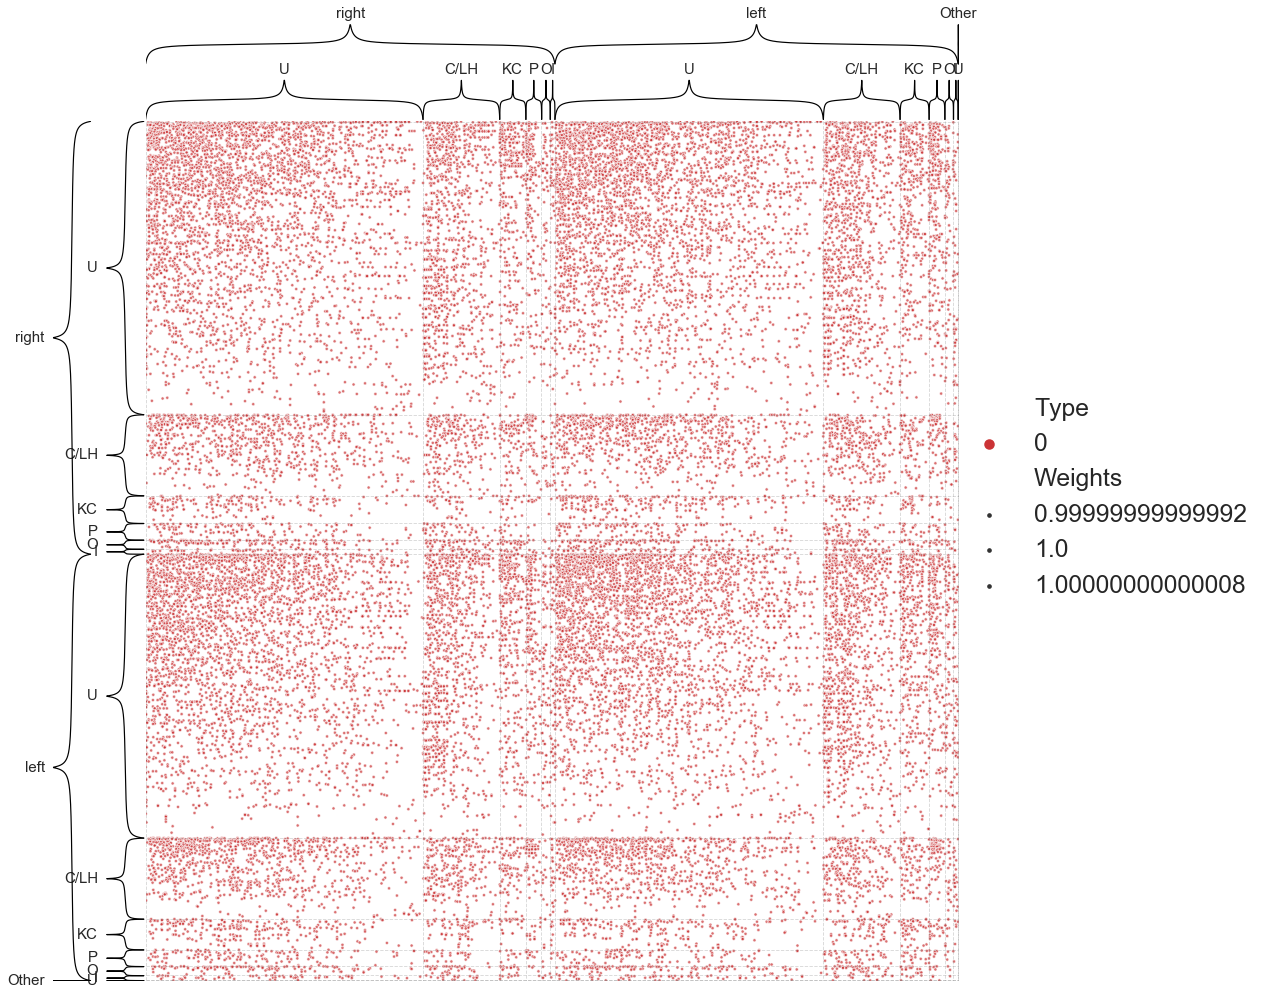

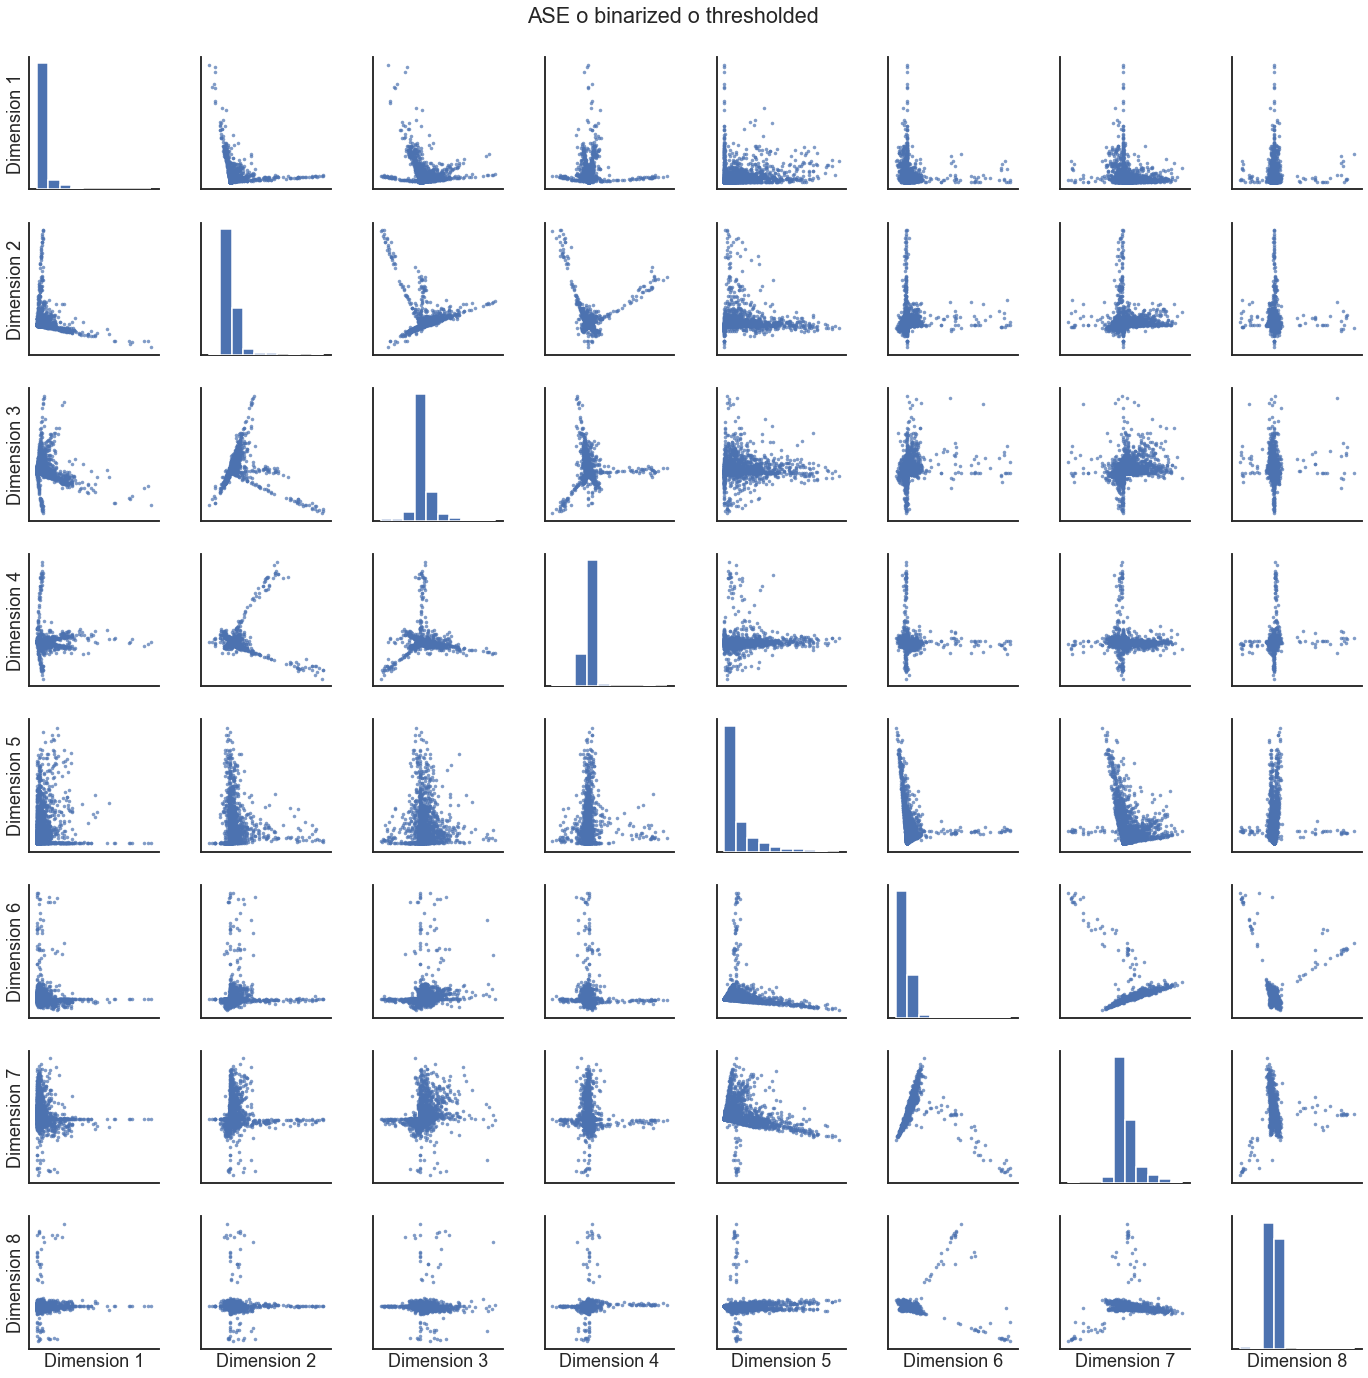

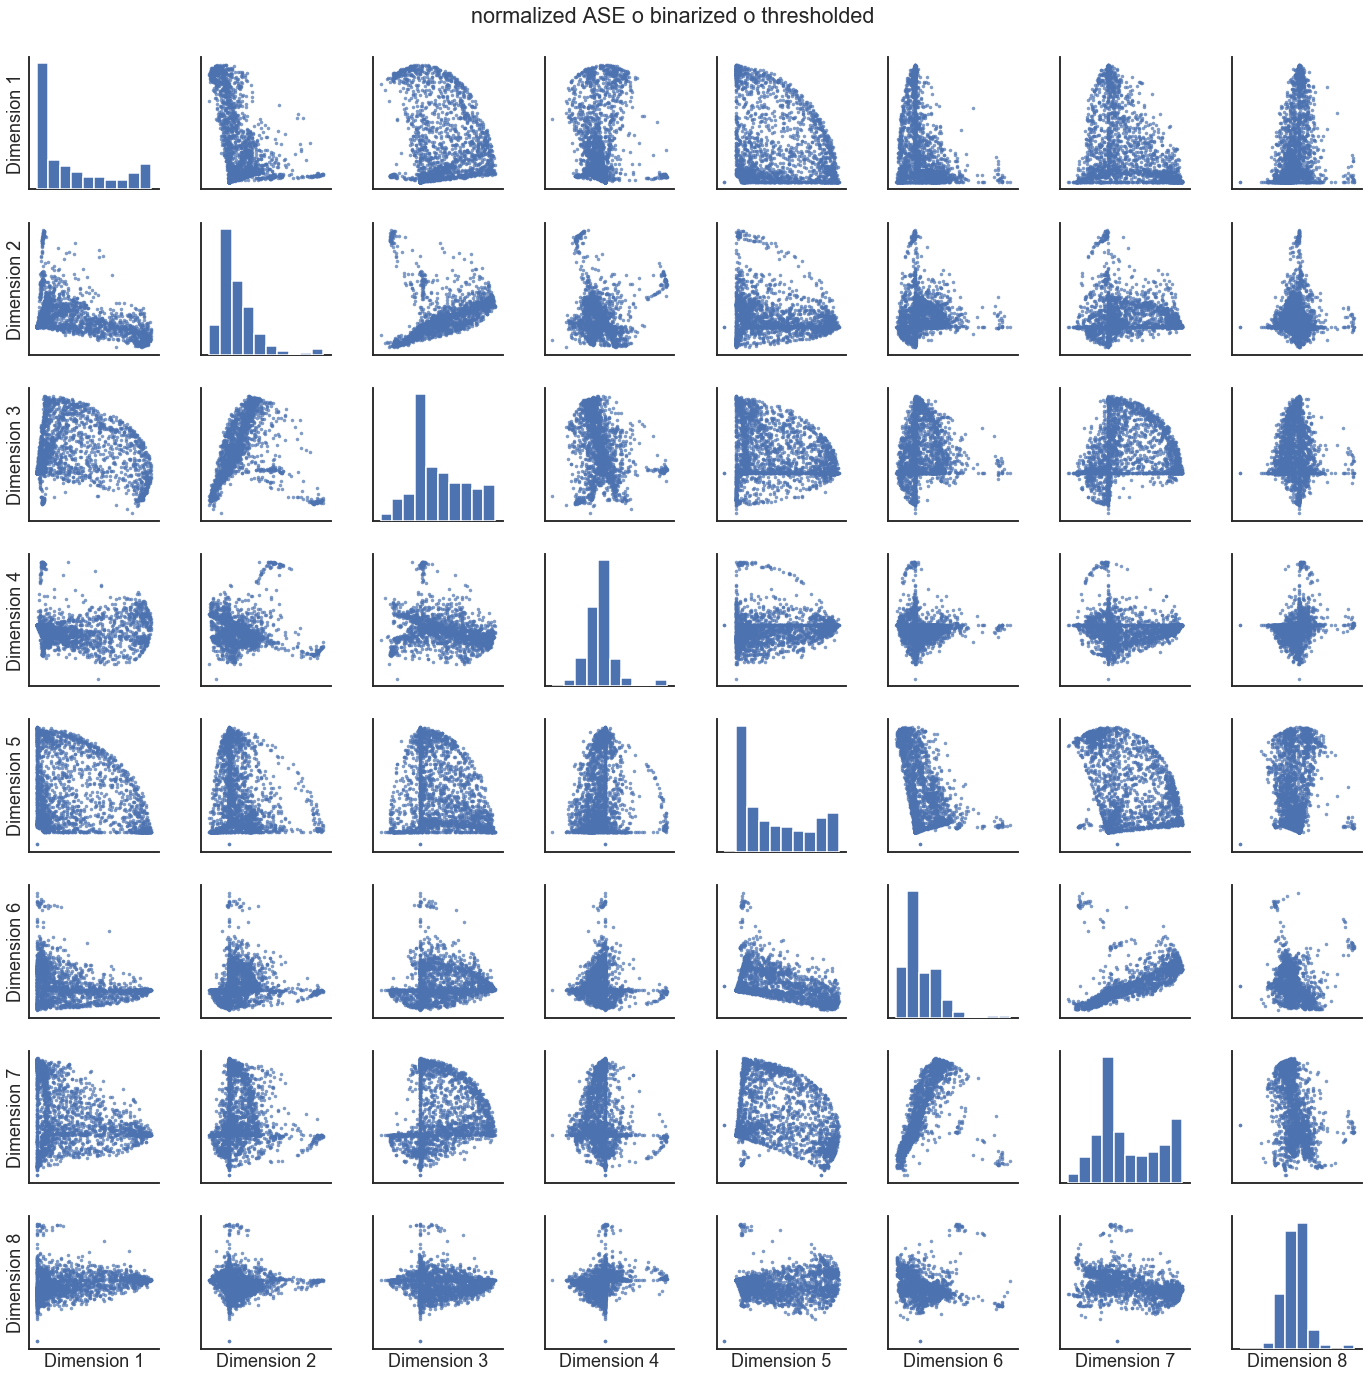

In [6]:
print("Embedding binarized graph, n_components from ZG1")
print("Red shows elbows [1, 2, 3] found by ZG")
n_components = None
n_elbows = 1
embed_graph = binarize(lcc_graph_t)
screeplot(embed_graph, cumulative=False, show_first=20, n_elbows=3)

gridplot_kws["sizes"] = (10, 10)
gridplot(
    [embed_graph],
    inner_hier_labels=lcc_simple_classes,
    outer_hier_labels=lcc_hemisphere,
    **gridplot_kws,
)

ase = AdjacencySpectralEmbed(n_components=n_components, n_elbows=n_elbows)
latent = ase.fit_transform(embed_graph)
latent = np.concatenate(latent, axis=-1)
pairplot(latent, title="ASE o binarized o thresholded")


norm_latent = latent / np.linalg.norm(latent, axis=1)[:, np.newaxis]
pairplot(norm_latent, title="normalized ASE o binarized o thresholded");

# this is the same as (norm_latent @ norm_latent.T) - min()
# dists = pairwise_distances(norm_latent, metric="cosine")

# Fitting HSBM
- note that many of the subgraphs found by spherical k-means under the hood are not a single connected component
- k-means optimal number of clusters is found by silhouette score

In [7]:
print("Fitting HSBM")

fit_graph = embed_graph
n_subgroups = 3  # this only affects the dissimilarity clustering
n_subgraphs = 15  # maximum number of subgraphs
n_components_lvl1 = None  # this will use ZG1
n_components_lvl2 = None  # this will use ZG2
cluster_kws = dict(n_init=100)
hsbm = HSBMEstimator(
    n_levels=2,
    n_subgraphs=n_subgraphs,
    n_subgroups=n_subgroups,
    n_components_lvl1=n_components_lvl1,
    n_components_lvl2=n_components_lvl2,
    cluster_kws=cluster_kws,
    cluster_method="sphere-kmeans",
    n_elbows=1,
)
hsbm.fit(fit_graph);

Fitting HSBM


/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/b

# Partition of the global ASE by spherical k-means

Plotting spherical kmeans clustering result on normalized ASE, ZG1


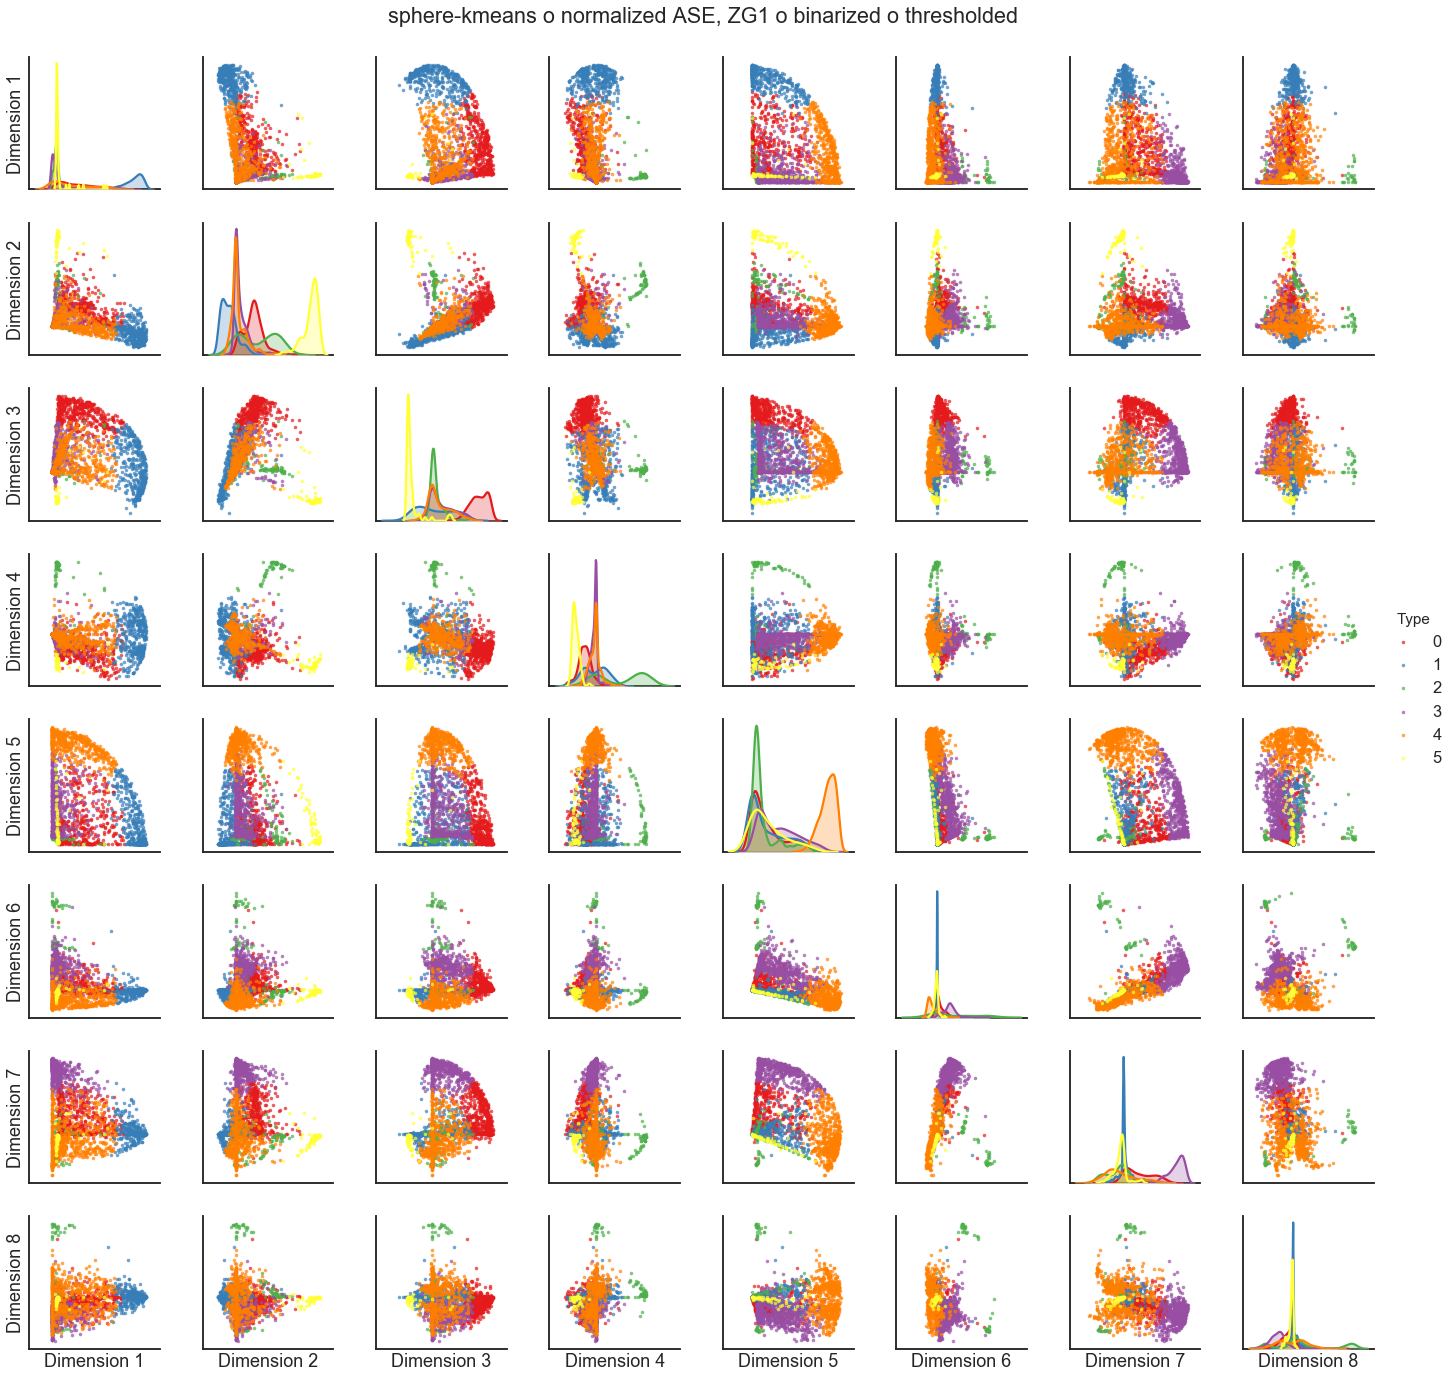

In [8]:
print("Plotting spherical kmeans clustering result on normalized ASE, ZG1")
latent = hsbm.latent_
labels = hsbm.vertex_assignments_
pairplot(
    latent,
    labels=labels,
    title="sphere-kmeans o normalized ASE, ZG1 o binarized o thresholded",
);

# Whole graph sorted by spherical k-means result

Plotting graph sorted by kmeans clustering result


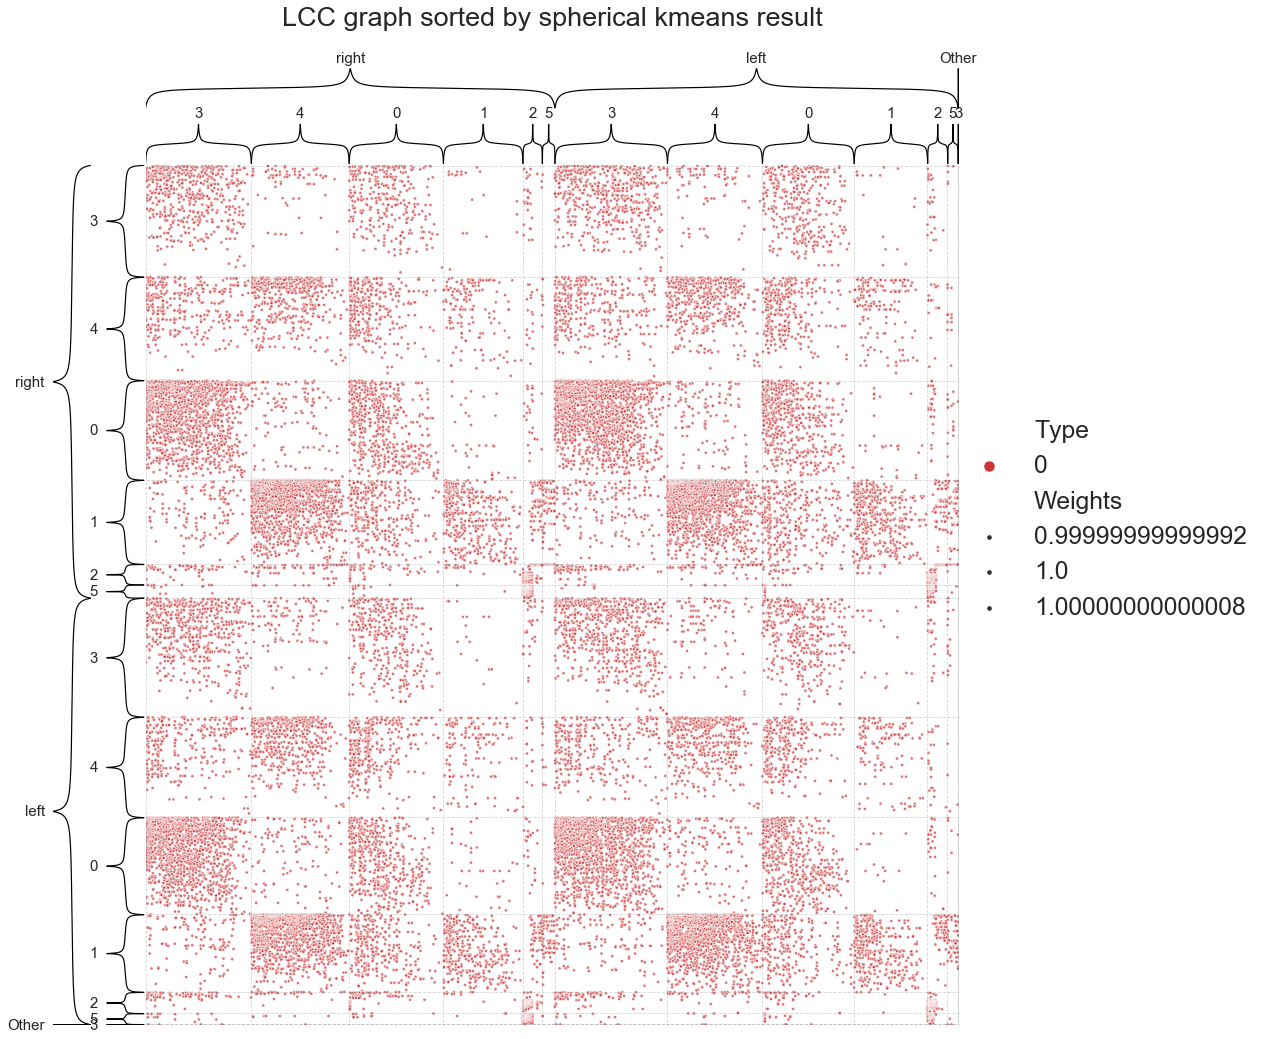

In [9]:
print("Plotting graph sorted by kmeans clustering result")
gridplot(
    [embed_graph],
    inner_hier_labels=labels,
    outer_hier_labels=lcc_hemisphere,
    title="LCC graph sorted by spherical kmeans result",
    **gridplot_kws,
);

# Dissimilarities of subgraphs found by spherical k-means

Plotting subgraph dissimilarities


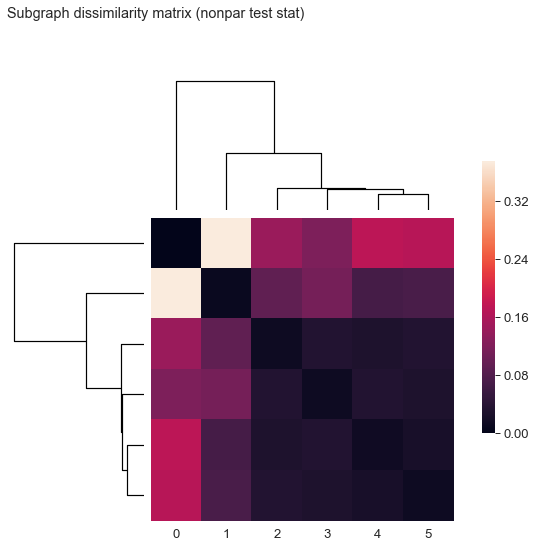

In [10]:
print("Plotting subgraph dissimilarities")
dists = hsbm.subgraph_dissimilarities_
dists -= dists.min()
hierplot(dists)
plt.title("Subgraph dissimilarity matrix (nonpar test stat)", pad=200, loc="left");

# Size of each subgraph

In [11]:
for subgraph in hsbm.subgraphs_: 
    print(subgraph.shape[0])

519
427
110
609
539
64


# Show the largest subgraph that was found

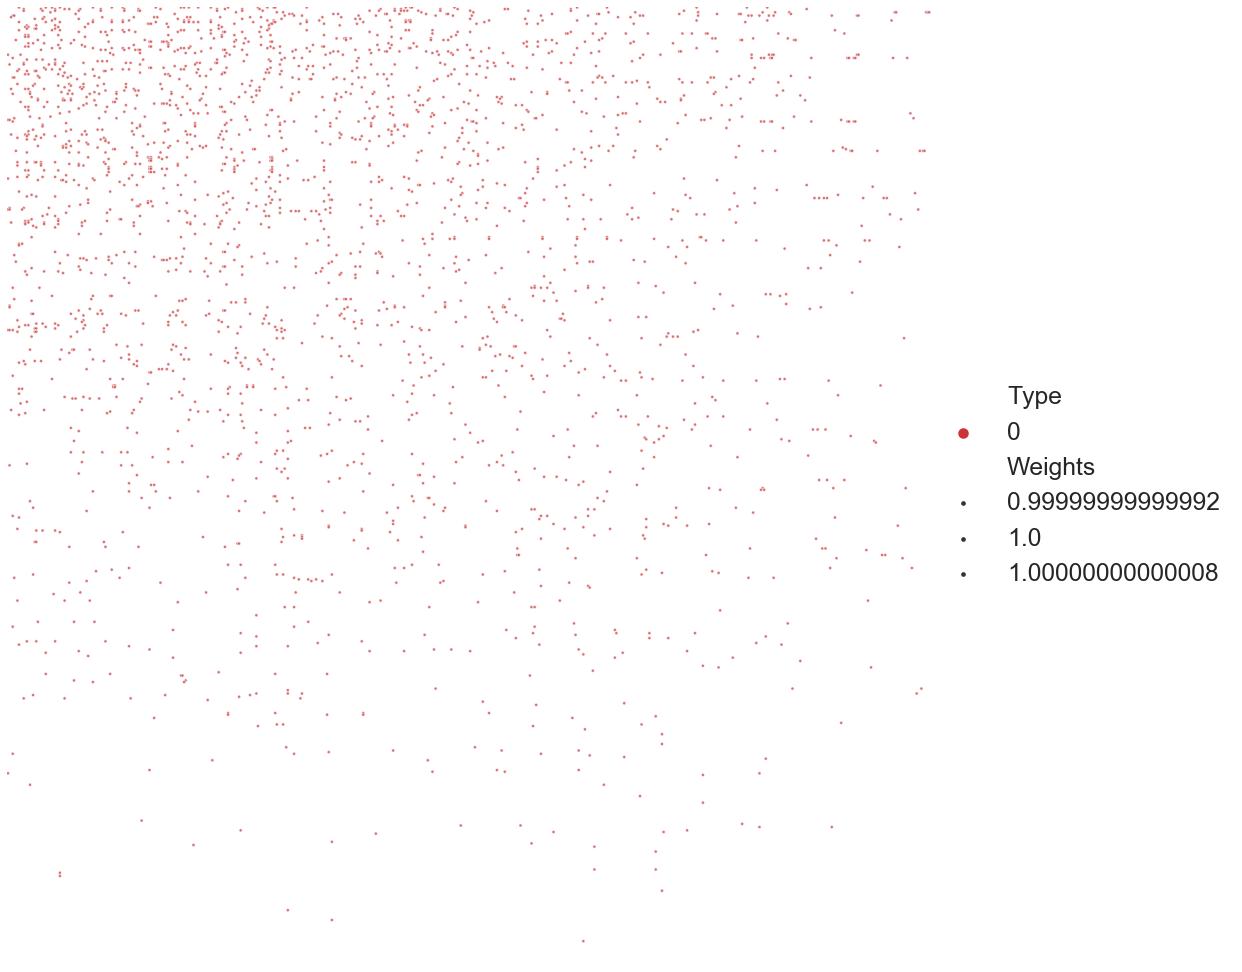

In [12]:
subgraph_try = hsbm.subgraphs_[3]
subgraph_try = get_lcc(subgraph_try)
gridplot([subgraph_try], **gridplot_kws);

# Fit HSBM to a subgraph (recurse) 

In [13]:
print("Fitting HSBM on a subgraph")

n_subgroups = 3  # this only affects the dissimilarity clustering
n_subgraphs = 15  # maximum number of subgraphs
n_components_lvl1 = None  # this will use ZG1
n_components_lvl2 = None  # this will use ZG2
cluster_kws = dict(n_init=100)
recurse_hsbm = HSBMEstimator(
    n_levels=2,
    n_subgraphs=n_subgraphs,
    n_subgroups=n_subgroups,
    n_components_lvl1=n_components_lvl1,
    n_components_lvl2=n_components_lvl2,
    cluster_kws=cluster_kws,
    cluster_method="sphere-kmeans",
    n_elbows=1,
)
recurse_hsbm.fit(subgraph_try);

Fitting HSBM on a subgraph


/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/bpedigo/JHU_code/graspy/graspy/embed/ase.py:138: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/Users/b

# Normalized embedding colored by k-means result for this subgraph

Plotting spherical kmeans clustering result for a subgraph


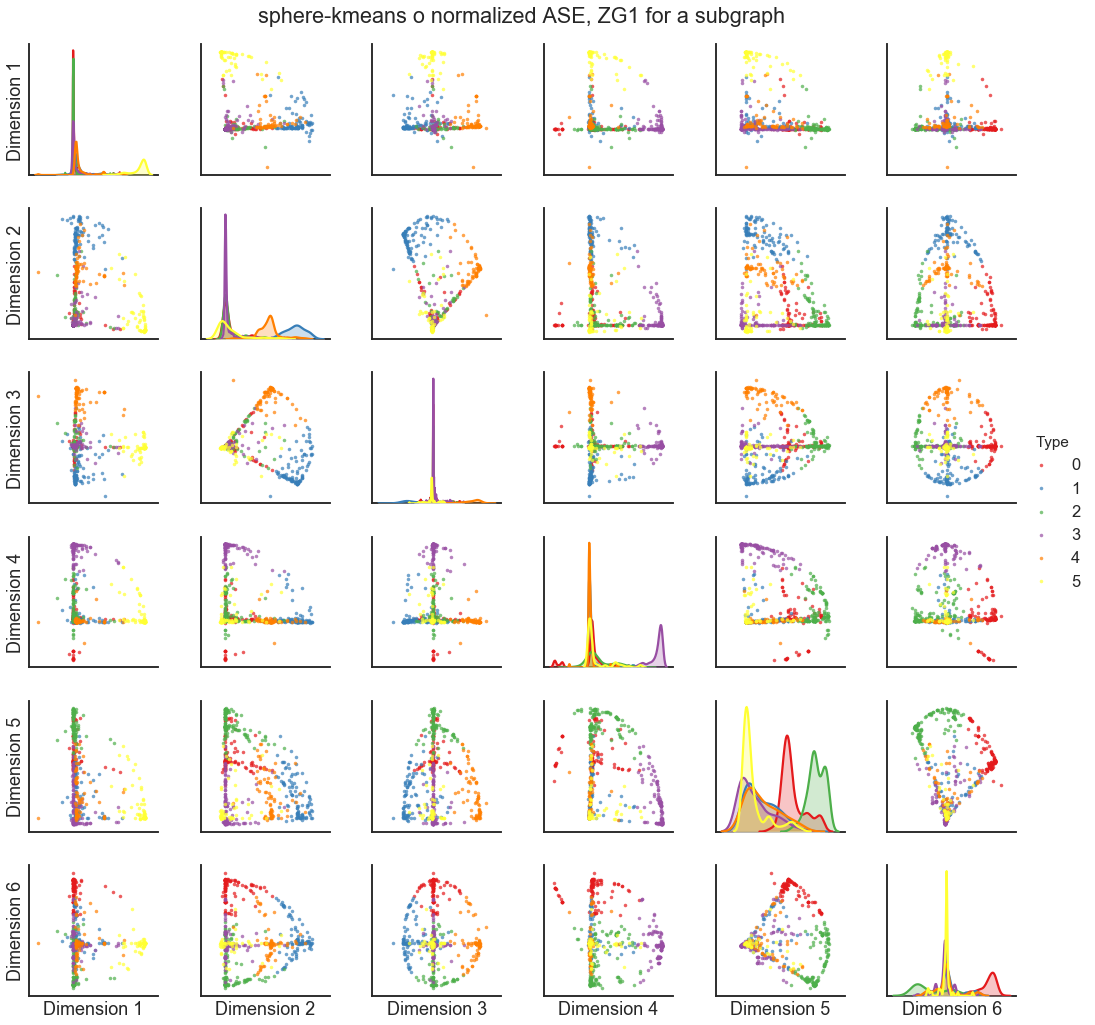

In [14]:
print("Plotting spherical kmeans clustering result for a subgraph")
latent = recurse_hsbm.latent_
labels = recurse_hsbm.vertex_assignments_
pairplot(
    latent,
    labels=labels,
    title="sphere-kmeans o normalized ASE, ZG1 for a subgraph",
);

# Subgraph sorted by spherical k-means result

Plotting graph sorted by kmeans clustering result


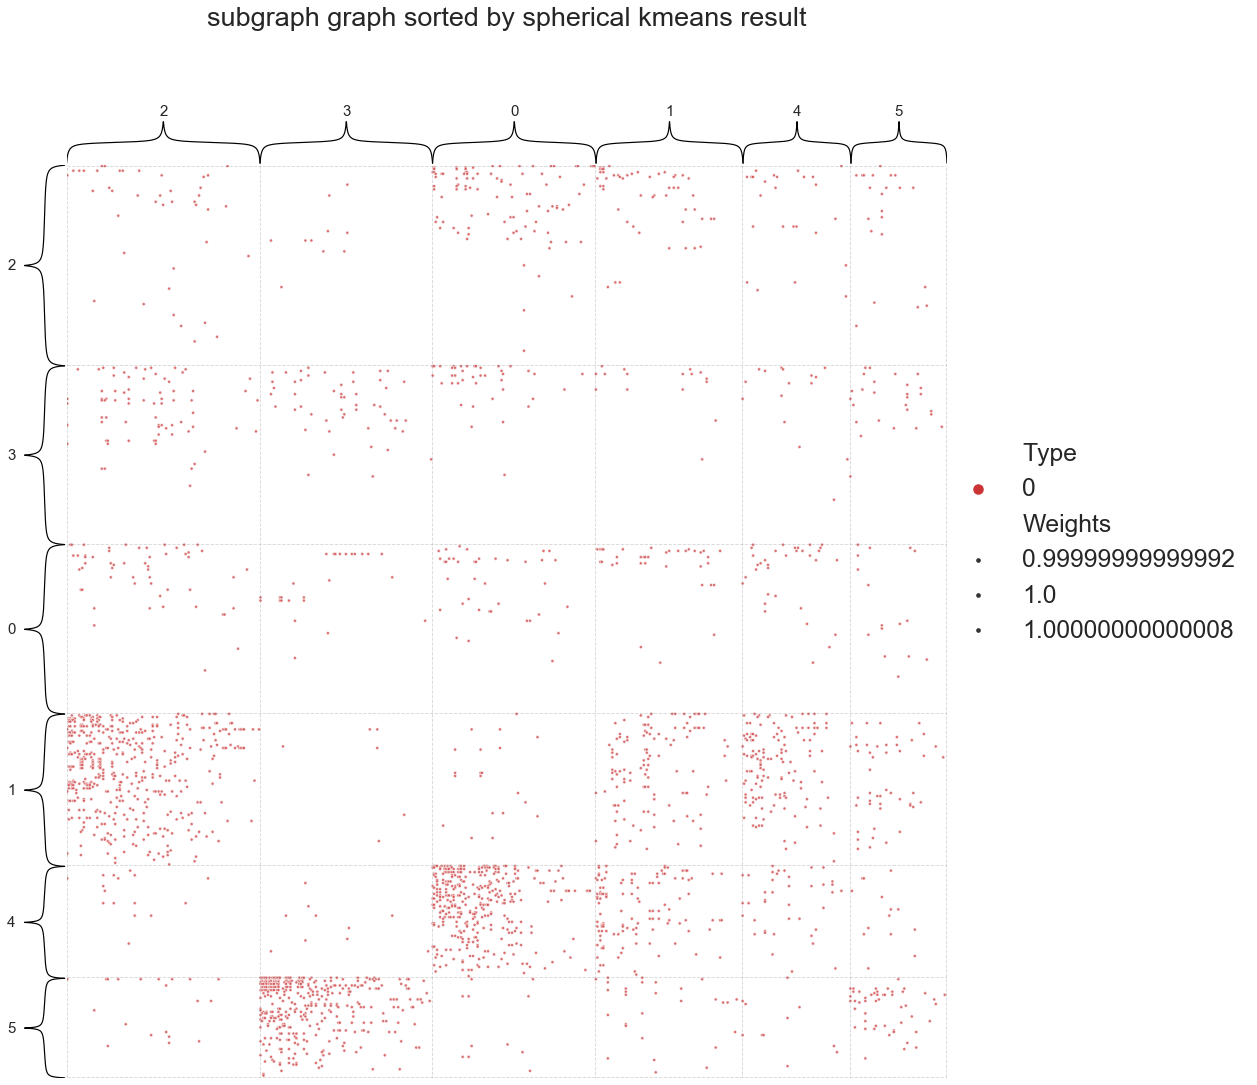

In [15]:
print("Plotting graph sorted by kmeans clustering result")
gridplot(
    [subgraph_try],
    inner_hier_labels=labels,
    title="subgraph graph sorted by spherical kmeans result",
    **gridplot_kws,
);


# Subsubgraph dissimilarities

Plotting subgraph dissimilarities


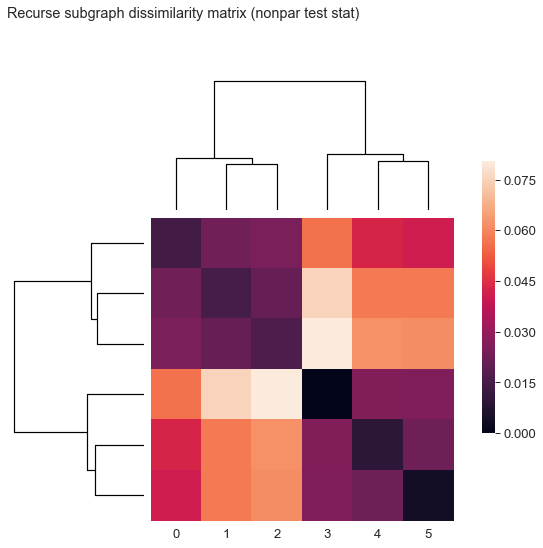

In [16]:
print("Plotting subgraph dissimilarities")
dists = recurse_hsbm.subgraph_dissimilarities_
dists -= dists.min()
hierplot(dists)
plt.title("Recurse subgraph dissimilarity matrix (nonpar test stat)", pad=200, loc="left");